# 데이터 적재

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image

## 데이터 시각화

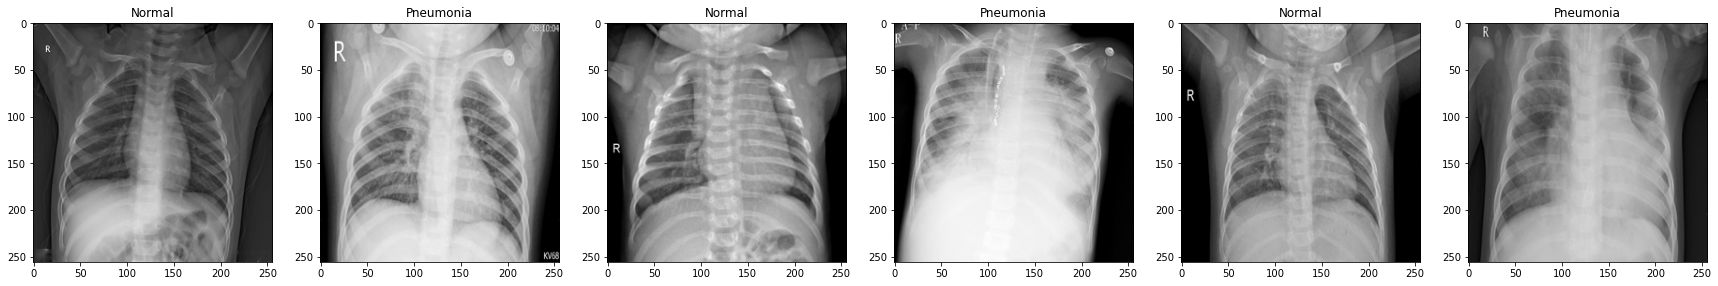

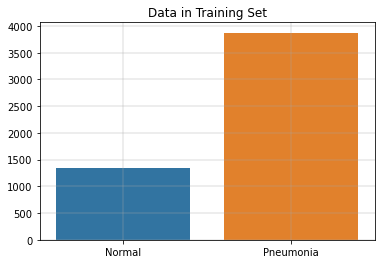

In [2]:
pneumonia = glob('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*')
normal = glob('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/*')

fig, ax = plt.subplots(1,6, figsize=(30,10))

for i in range(6):
    if i % 2 == 0:
        current_img = Image.open(normal[i]).resize((256,256))
        title = 'Normal'
    elif i % 2 == 1:
        current_img = Image.open(pneumonia[i]).resize((256,256))
        title = 'Pneumonia'
        
    ax[i].imshow(current_img, cmap='gray')
    ax[i].set_title(title)

plt.show()

categories = ["Normal", "Pneumonia"]
xray_amounts = [len(normal), len(pneumonia)]
sns.barplot(categories, xray_amounts)
plt.title('Data in Training Set')
plt.grid(color='#a8a8a8', linewidth=0.4)
plt.show()

## 테스트 데이터 분리

In [3]:
def process_img(img, label):
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    return img, label

train_ds = image_dataset_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/train',
    labels='inferred',
    shuffle=True,
    batch_size=64,
    image_size=(256,256),
    color_mode='grayscale',
    label_mode='binary',
    interpolation='nearest'
).map(process_img)

test_ds = image_dataset_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/test',
    labels='inferred',
    shuffle=False,
    batch_size=64,
    image_size=(256,256),
    color_mode='grayscale',
    label_mode='binary',
    interpolation='nearest'
).map(process_img)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


## 모델 생성

In [4]:
model = keras.Sequential([
    layers.InputLayer(input_shape=(256,256,1)),

    # Data Augmentation
    preprocessing.RandomContrast(0.3),
    preprocessing.RandomRotation(0.2),

    # Body
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

    # Head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

## Compiling the model
I used the Adam optimizer with a learning rate of 1e-4 or 0.0001

In [5]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast (RandomContr (None, 256, 256, 1)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 64)      3

## 모델 훈련

In [6]:
early_stopping = EarlyStopping(
    min_delta = 1e-3,
    patience=3,
    restore_best_weights=True,
    verbose=1
)

ckpt = ModelCheckpoint(
    'pneumonia-weights.hdf5',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=(test_ds),
    batch_size=64,
    epochs=200,
    callbacks=[early_stopping, ckpt],
    verbose=1
)

Epoch 1/200
82/82 [==============================] - ETA: 0s - loss: 0.6247 - binary_accuracy: 0.7419
Epoch 00001: val_loss improved from inf to 0.68213, saving model to pneumonia-weights.hdf5
82/82 [==============================] - 84s 1s/step - loss: 0.6247 - binary_accuracy: 0.7419 - val_loss: 0.6821 - val_binary_accuracy: 0.6250
Epoch 2/200
82/82 [==============================] - ETA: 0s - loss: 0.5695 - binary_accuracy: 0.7429
Epoch 00002: val_loss did not improve from 0.68213
82/82 [==============================] - 49s 600ms/step - loss: 0.5695 - binary_accuracy: 0.7429 - val_loss: 0.6899 - val_binary_accuracy: 0.6250
Epoch 3/200
82/82 [==============================] - ETA: 0s - loss: 0.5570 - binary_accuracy: 0.7429
Epoch 00003: val_loss improved from 0.68213 to 0.63736, saving model to pneumonia-weights.hdf5
82/82 [==============================] - 50s 609ms/step - loss: 0.5570 - binary_accuracy: 0.7429 - val_loss: 0.6374 - val_binary_accuracy: 0.6250
Epoch 4/200
82/82 [===

## 모델 평가

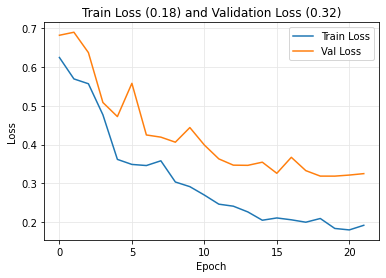

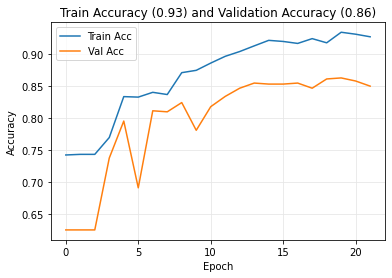

In [7]:
fit_hist = pd.DataFrame(history.history)

loss = round(np.min(fit_hist['loss']), 2)
val_loss = round(np.min(fit_hist['val_loss']), 2)
acc = round(np.max(fit_hist['binary_accuracy']), 2)
val_acc = round(np.max(fit_hist['val_binary_accuracy']), 2)

plt.title(f"Train Loss ({loss}) and Validation Loss ({val_loss})")
plt.plot(fit_hist['loss'], label='Train Loss')
plt.plot(fit_hist['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(color='#e6e6e6')
plt.legend()
plt.show()

plt.title(f"Train Accuracy ({acc}) and Validation Accuracy ({val_acc})")
plt.plot(fit_hist['binary_accuracy'], label='Train Acc')
plt.plot(fit_hist['val_binary_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(color='#e6e6e6')
plt.legend()
plt.show()